Requirements.txt file for virtualenv

Keras
numpy
astropy
jupyter

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import os
from astropy.io import fits
import numpy as np
import random

from keras.models import Sequential
from keras.utils import np_utils

# convlulation layres to help train on image data
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D

# optimizers
from keras.optimizers import SGD

# core layers
from keras.layers import Activation, Dropout, Flatten, Dense

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

## Setup Defaults

In [12]:
display = True
labels = ['750', '850']
path='/Users/crjones/Documents/Science/HargisDDRF/astroNN/data/wl_maps'
degrade=8
nct = 9
imsize=64

## Load in the Data

In [13]:
imgs = np.zeros([2048//degrade, 2048//degrade, nct, len(labels)])
data = []
for j, label in enumerate(labels):
    for i in range(nct):
        filename = os.path.join(path, 'smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.'+label+'_4096xy_000'+ np.str(i+1) +'r_0029p_0100z_og.gre.fit')
        if display:
           print("i: %d  j: %d  name: %s" % (i, j, 'smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.'+label+'_4096xy_000'+ np.str(i+1) +'r_0029p_0100z_og.gre.fit'))

        # Read in the data and put into the imgs.
        f = fits.open(filename)
        
        tt = blockshaped(rebin(f[0].data, [2048//degrade, 2048//degrade]), imsize, imsize)
        
        for smimg in tt:
            data.append( (int(label), i, smimg) ) 

i: 0  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0001r_0029p_0100z_og.gre.fit
i: 1  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0002r_0029p_0100z_og.gre.fit
i: 2  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0003r_0029p_0100z_og.gre.fit
i: 3  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0004r_0029p_0100z_og.gre.fit
i: 4  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0005r_0029p_0100z_og.gre.fit
i: 5  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0006r_0029p_0100z_og.gre.fit
i: 6  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0007r_0029p_0100z_og.gre.fit
i: 7  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0008r_0029p_0100z_og.gre.fit
i: 8  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.74

In [14]:
indices_training = np.random.choice(range(len(data)), 900)
indices_validation = np.random.choice(list(set(range(len(data))) - set(indices_training)), 50)
indicies_testing = list( set(range(len(data))) - set(indices_training) - set(indices_validation))

# 
#indices_training = [ii for ii,x in enumerate(data) if x[1] < 7]
#indices_validation = [ii for ii,x in enumerate(data) if x[1] == 7]
#indicies_testing = [ii for ii,x in enumerate(data) if x[1] == 8]

## Rotate, transpose the data to create new sets

In [15]:
#  Create the 8x8 sub images from the image just read in
training_imgs = []
training_labels = []

# Setup the shift variables (taken from 4_conv_WL notebook)
exp_cut, exp_nshift = 3, 3
npanelx = 2**exp_cut
panelw = 2048//(degrade*npanelx)
nshift = 2**exp_nshift - 1
shiftw = panelw // npanelx

# Grab the list of 8x8 sub arrays
#temp_training_imgs = [im for ii in indices_training for im in blockshaped(data[ii][2],imsize,imsize) ]
#temp_labels = [im for ii in indices_training for im in data[ii][0]]

temp_training_imgs = []
temp_labels = []
for ii in indices_training:
    temp_training_imgs.append(data[ii][2])
    temp_labels.append(data[ii][0])

# Add in all the shifts
temp_training_imgs.extend([np.roll(x, (r,c), axis=(0,1)) 
     for x in temp_training_imgs 
     for r in [1,  5,  9, 13, 17, 21, 25] 
     for c in [1,  5,  9, 13, 17, 21, 25]
])
temp_labels.extend([tl 
                    for tl in temp_labels 
                    for r in [1,  5,  9, 13, 17, 21, 25] 
                    for c in [1,  5,  9, 13, 17, 21, 25]
                   ])

# Now create all the flips, rotations, transpositions etc
training_imgs.extend(temp_training_imgs)  # sub images
training_labels.extend(temp_labels)

training_imgs.extend([x.T for x in temp_training_imgs]) # transposed sub images
training_labels.extend(temp_labels)

training_imgs.extend([np.rot90(x) for x in temp_training_imgs]) # rotated sub images
training_labels.extend(temp_labels)

training_imgs.extend([np.rot90(x, k=2) for x in temp_training_imgs]) # rotated twice sub images
training_labels.extend(temp_labels)

training_imgs.extend([np.rot90(x, k=3) for x in temp_training_imgs]) # rotated three x sub images
training_labels.extend(temp_labels)

training_imgs.extend([x[::-1] for x in temp_training_imgs]) # flip ud
training_labels.extend(temp_labels)

training_imgs.extend([x[:,::-1] for x in temp_training_imgs]) # flip lr
training_labels.extend(temp_labels)


## Create Training Data


In [16]:
# Now make them into a 3D array and 1D array
X_train = np.stack(training_imgs)
y_train = training_labels

# Add dimension to X_train for keras
X_train = X_train.reshape(X_train.shape[0], 1, imsize, imsize)

# change y_train to labels of 0 and 1 (conversion of boolean to int)
y_train = np.array(y_train) == 850
y_train = np_utils.to_categorical(y_train, 2)

# YIKES https://github.com/ml4a/ml4a-guides/issues/10  !!!!!!!!!!!
from keras import backend as K
K.set_image_dim_ordering('th')

## Create Validation Data

In [17]:
# Extend the X_test and y_test with the '850' data
X_validation = [data[ii][2] for ii in indices_validation]
y_validation = [data[ii][0] for ii in indices_validation]

# Now make them into a 3D array and 1D array
X_validation = np.stack(X_validation)
y_validation = np.array(y_validation)

# Add dimension to X_train for keras
X_validation = X_validation.reshape(X_validation.shape[0], 1, imsize, imsize)

# change y_test to labels of 0 and 1 (conversion of boolean to int)
y_validation = np.array(y_validation == 850)*1
y_validation = np_utils.to_categorical(y_validation, 2)

## Setup The Keras Model
One note on this part. There was an issue, originally of setting the filter size in this step to anything larger than (1,1).  After Googling around it appears that it had to do with an issue in Keras (described here https://github.com/ml4a/ml4a-guides/issues/10). It seems the order of the image dimensions had a conflict.  With the 2 line fix immediately above this all runs fine. 

In [24]:
model = Sequential()

# input is 4D tensor with shape: (samples, channels, rows, cols)
# output is 4D tensor with shape: (samples, filters, new_rows, new_cols)
model.add(Conv2D(32, (5, 5), strides=(3,3), activation='relu', input_shape=(1, imsize, imsize)))

#model.add(Conv2D(64, (3, 3), strides=(3,3), activation='relu'))

model.add(Conv2D(64, (5, 5), activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu'))

# MaxPooling2D is a way to reduce the number of parameters in our model by
# sliding a 2x2 pooling filter across the previous layer and taking the max of
# the 4 values in the 2x2 filter.
#model.add(MaxPooling2D(pool_size=(3,3)))

# https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='mean_squared_logarithmic_error',
        optimizer='adam', metrics=['accuracy', 'mae', 'mape'])


## Fit model on Training Data

In [25]:
model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, verbose=1)

Train on 315000 samples, validate on 50 samples
Epoch 1/10
 10432/315000 [..............................] - ETA: 1733s - loss: 0.1221 - acc: 0.5358 - mean_absolute_error: 0.4912 - mean_absolute_percentage_error: 245590398.9693

KeyboardInterrupt: 

## Create the testing data set 

In [254]:
# Extend the X_test and y_test with the '850' data
X_test = [data[ii][2] for ii in indicies_testing]
y_test = [data[ii][0] for ii in indicies_testing]

# Now make them into a 3D array and 1D array
X_test = np.stack(X_test)
y_test = np.array(y_test)

# Add dimension to X_train for keras
X_test = X_test.reshape(X_test.shape[0], 1, imsize, imsize)

# change y_test to labels of 0 and 1 (conversion of boolean to int)
y_test = np.array(y_test == 850)*1
y_test = np_utils.to_categorical(y_test, 2)

## Evaluate the model

In [255]:
scores = model.evaluate(X_test, y_test, verbose=1)
names = model.metrics_names
print('{}={}, {}={}, {}={}, {}={}'.format(names[0], scores[0], names[1], scores[1], names[2], scores[2], names[3], scores[3]))

416/482 [========================>.....] - ETA: 0sloss=0.8749909314377179, acc=0.6804979253112033, mean_absolute_error=0.3329025641763853, mean_absolute_percentage_error=166451300.58091286


In [245]:
l1 = model.layers[0]

In [246]:
ws = l1.get_weights()

In [247]:
len(ws)

2

(-0.5, 31.5, -0.5, 2.5)

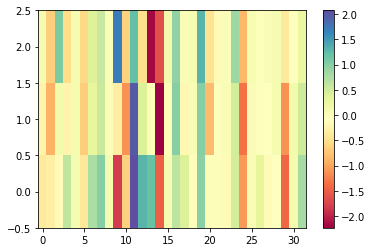

In [248]:
plt.imshow(np.vstack(ws[0][0]))
plt.colorbar()
plt.axis('auto')